In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType, DoubleType

In [2]:
spark = SparkSession.builder.appName('covid19_daily').getOrCreate()

In [3]:
file_path = './data/us_states_covid19_daily.csv'

In [4]:
state_df = (spark.read.format('csv')
            .option('header', True)
            .option('inferSchema', True)
            .load(file_path))

In [5]:
state_df = state_df.select(['date', 'state', 'positive'])
state_df.show()

+--------+-----+--------+
|    date|state|positive|
+--------+-----+--------+
|20201206|   AK|   35720|
|20201206|   AL|  269877|
|20201206|   AR|  170924|
|20201206|   AS|       0|
|20201206|   AZ|  364276|
|20201206|   CA| 1341700|
|20201206|   CO|  260581|
|20201206|   CT|  127715|
|20201206|   DC|   23136|
|20201206|   DE|   39912|
|20201206|   FL| 1040727|
|20201206|   GA|  443822|
|20201206|   GU|    7004|
|20201206|   HI|   18842|
|20201206|   IA|  213390|
|20201206|   ID|  109705|
|20201206|   IL|  787573|
|20201206|   IN|  381617|
|20201206|   KS|  168295|
|20201206|   KY|  200632|
+--------+-----+--------+
only showing top 20 rows



### Define datetime

In [6]:
from pyspark.sql.functions import to_date

state_df = state_df.withColumn('date', state_df['date'].cast(StringType()))
state_df = state_df.withColumn('date', to_date(state_df['date'], 'yyyyMMdd'))
state_df.show()

+----------+-----+--------+
|      date|state|positive|
+----------+-----+--------+
|2020-12-06|   AK|   35720|
|2020-12-06|   AL|  269877|
|2020-12-06|   AR|  170924|
|2020-12-06|   AS|       0|
|2020-12-06|   AZ|  364276|
|2020-12-06|   CA| 1341700|
|2020-12-06|   CO|  260581|
|2020-12-06|   CT|  127715|
|2020-12-06|   DC|   23136|
|2020-12-06|   DE|   39912|
|2020-12-06|   FL| 1040727|
|2020-12-06|   GA|  443822|
|2020-12-06|   GU|    7004|
|2020-12-06|   HI|   18842|
|2020-12-06|   IA|  213390|
|2020-12-06|   ID|  109705|
|2020-12-06|   IL|  787573|
|2020-12-06|   IN|  381617|
|2020-12-06|   KS|  168295|
|2020-12-06|   KY|  200632|
+----------+-----+--------+
only showing top 20 rows



In [7]:
state_df.printSchema()

root
 |-- date: date (nullable = true)
 |-- state: string (nullable = true)
 |-- positive: integer (nullable = true)



In [8]:
from pyspark.sql.functions import max
from pyspark.sql.functions import col

(state_df.groupBy('state')
         .agg(max(col('positive')).alias('state_max'))
         .orderBy('state_max', ascending=False).show())

+-----+---------+
|state|state_max|
+-----+---------+
|   CA|  1341700|
|   TX|  1249323|
|   FL|  1040727|
|   IL|   787573|
|   NY|   705827|
|   OH|   475024|
|   GA|   443822|
|   WI|   441067|
|   MI|   426576|
|   PA|   420114|
|   TN|   400594|
|   NC|   394990|
|   IN|   381617|
|   NJ|   368016|
|   AZ|   364276|
|   MN|   350862|
|   MO|   322298|
|   AL|   269877|
|   CO|   260581|
|   MA|   256844|
+-----+---------+
only showing top 20 rows



In [9]:
il_df = state_df.filter(col('state') == 'IL')
il_df.show(10)

+----------+-----+--------+
|      date|state|positive|
+----------+-----+--------+
|2020-12-06|   IL|  787573|
|2020-12-05|   IL|  779975|
|2020-12-04|   IL|  770088|
|2020-12-03|   IL|  759562|
|2020-12-02|   IL|  748603|
|2020-12-01|   IL|  738846|
|2020-11-30|   IL|  726304|
|2020-11-29|   IL|  720114|
|2020-11-28|   IL|  712936|
|2020-11-27|   IL|  705063|
+----------+-----+--------+
only showing top 10 rows



### Create a column showing the number of daily new cases

In [10]:
from pyspark.sql.functions import lag, isnull, when
from pyspark.sql.window import Window

# Create a new column showing the number of new cases
il_df = il_df.withColumn('prev_cases', 
                         lag(il_df['positive']).over(Window.partitionBy().orderBy('date')))
il_df = il_df.withColumn('il_new_cases', 
                         when(isnull(il_df['positive'] - il_df['prev_cases']), il_df['positive'])
                         .otherwise(il_df['positive'] - il_df['prev_cases']))
il_df = il_df.withColumnRenamed('date', 'il_date')
il_df = il_df.drop('prev_cases')

In [11]:
il_df.show(10)

+----------+-----+--------+------------+
|   il_date|state|positive|il_new_cases|
+----------+-----+--------+------------+
|2020-03-04|   IL|       4|           4|
|2020-03-05|   IL|       5|           1|
|2020-03-06|   IL|       5|           0|
|2020-03-07|   IL|       6|           1|
|2020-03-08|   IL|       6|           0|
|2020-03-09|   IL|       7|           1|
|2020-03-10|   IL|      19|          12|
|2020-03-11|   IL|      19|           0|
|2020-03-12|   IL|      25|           6|
|2020-03-13|   IL|      32|           7|
+----------+-----+--------+------------+
only showing top 10 rows



In [12]:
il_df.printSchema()

root
 |-- il_date: date (nullable = true)
 |-- state: string (nullable = true)
 |-- positive: integer (nullable = true)
 |-- il_new_cases: integer (nullable = true)



### Get the national case numbers

In [13]:
from pyspark.sql.functions import sum
us_df = state_df.groupBy('date').agg(sum('positive').alias('us_positive'))
us_df.show()

+----------+-----------+
|      date|us_positive|
+----------+-----------+
|2020-08-24|    5690238|
|2020-11-29|   13191020|
|2020-08-05|    4782450|
|2020-07-24|    4083294|
|2020-08-29|    5904458|
|2020-08-28|    5860495|
|2020-04-30|    1073745|
|2020-10-04|    7349267|
|2020-09-24|    6911232|
|2020-03-13|       3745|
|2020-03-07|        631|
|2020-02-15|          0|
|2020-02-04|          0|
|2020-05-23|    1626355|
|2020-02-12|          0|
|2020-09-07|    6249594|
|2020-05-08|    1285663|
|2020-06-04|    1872266|
|2020-05-24|    1645215|
|2020-10-18|    8076834|
+----------+-----------+
only showing top 20 rows



In [14]:
# Create a new column showing the number of new cases
us_df = us_df.withColumn('prev_cases', 
                         lag(us_df['us_positive']).over(Window.partitionBy().orderBy('date')))
us_df = us_df.withColumn('us_new_cases', 
                         when(isnull(us_df['us_positive'] - us_df['prev_cases']), us_df['us_positive'])
                         .otherwise(us_df['us_positive'] - us_df['prev_cases']))
us_df = us_df.drop('prev_cases')
us_df.show()

+----------+-----------+------------+
|      date|us_positive|us_new_cases|
+----------+-----------+------------+
|2020-01-22|          0|           0|
|2020-01-23|          0|           0|
|2020-01-24|          0|           0|
|2020-01-25|          0|           0|
|2020-01-26|          0|           0|
|2020-01-27|          0|           0|
|2020-01-28|          0|           0|
|2020-01-29|          0|           0|
|2020-01-30|          0|           0|
|2020-01-31|          0|           0|
|2020-02-01|          0|           0|
|2020-02-02|          0|           0|
|2020-02-03|          0|           0|
|2020-02-04|          0|           0|
|2020-02-05|          0|           0|
|2020-02-06|          0|           0|
|2020-02-07|          0|           0|
|2020-02-08|          0|           0|
|2020-02-09|          0|           0|
|2020-02-10|          0|           0|
+----------+-----------+------------+
only showing top 20 rows



### Merge US and IL data

In [15]:
us_il_df = us_df.join(il_df, us_df['date'] == il_df['il_date'], how='outer')
us_il_df.show()

+----------+-----------+------------+-------+-----+--------+------------+
|      date|us_positive|us_new_cases|il_date|state|positive|il_new_cases|
+----------+-----------+------------+-------+-----+--------+------------+
|2020-01-22|          0|           0|   null| null|    null|        null|
|2020-01-23|          0|           0|   null| null|    null|        null|
|2020-01-24|          0|           0|   null| null|    null|        null|
|2020-01-25|          0|           0|   null| null|    null|        null|
|2020-01-26|          0|           0|   null| null|    null|        null|
|2020-01-27|          0|           0|   null| null|    null|        null|
|2020-01-28|          0|           0|   null| null|    null|        null|
|2020-01-29|          0|           0|   null| null|    null|        null|
|2020-01-30|          0|           0|   null| null|    null|        null|
|2020-01-31|          0|           0|   null| null|    null|        null|
|2020-02-01|          0|           0| 

In [16]:
us_il_df.printSchema()

root
 |-- date: date (nullable = true)
 |-- us_positive: long (nullable = true)
 |-- us_new_cases: long (nullable = true)
 |-- il_date: date (nullable = true)
 |-- state: string (nullable = true)
 |-- positive: integer (nullable = true)
 |-- il_new_cases: integer (nullable = true)



In [17]:
us_il_df = us_il_df.select(['date', 'us_new_cases', 'il_new_cases'])
us_il_df.show()

+----------+------------+------------+
|      date|us_new_cases|il_new_cases|
+----------+------------+------------+
|2020-01-22|           0|        null|
|2020-01-23|           0|        null|
|2020-01-24|           0|        null|
|2020-01-25|           0|        null|
|2020-01-26|           0|        null|
|2020-01-27|           0|        null|
|2020-01-28|           0|        null|
|2020-01-29|           0|        null|
|2020-01-30|           0|        null|
|2020-01-31|           0|        null|
|2020-02-01|           0|        null|
|2020-02-02|           0|        null|
|2020-02-03|           0|        null|
|2020-02-04|           0|        null|
|2020-02-05|           0|        null|
|2020-02-06|           0|        null|
|2020-02-07|           0|        null|
|2020-02-08|           0|        null|
|2020-02-09|           0|        null|
|2020-02-10|           0|        null|
+----------+------------+------------+
only showing top 20 rows



In [18]:
# fill zeros with null
us_il_df = us_il_df.na.fill(value=0)
us_il_df.show()

+----------+------------+------------+
|      date|us_new_cases|il_new_cases|
+----------+------------+------------+
|2020-01-22|           0|           0|
|2020-01-23|           0|           0|
|2020-01-24|           0|           0|
|2020-01-25|           0|           0|
|2020-01-26|           0|           0|
|2020-01-27|           0|           0|
|2020-01-28|           0|           0|
|2020-01-29|           0|           0|
|2020-01-30|           0|           0|
|2020-01-31|           0|           0|
|2020-02-01|           0|           0|
|2020-02-02|           0|           0|
|2020-02-03|           0|           0|
|2020-02-04|           0|           0|
|2020-02-05|           0|           0|
|2020-02-06|           0|           0|
|2020-02-07|           0|           0|
|2020-02-08|           0|           0|
|2020-02-09|           0|           0|
|2020-02-10|           0|           0|
+----------+------------+------------+
only showing top 20 rows



### Get the Bar Visit Data

In [19]:
import covidcast
from datetime import date

In [20]:
bar_visit_path = './data/bar_visit_il.csv'

In [21]:
bv_df = (spark.read.format('csv')
        .option('header', True)
        .option('inferSchema', True)
        .load(bar_visit_path))
bv_df = bv_df.select(['time_value', 'value'])
bv_df = bv_df.withColumn('date_bar_visit', to_date(bv_df['time_value'], 'yyyy-MM-dd'))
bv_df = bv_df.drop('time_value')
bv_df = bv_df.withColumnRenamed('value', 'bar_visit_per_100k')

In [22]:
bv_df.show(10)

+------------------+--------------+
|bar_visit_per_100k|date_bar_visit|
+------------------+--------------+
|   78.653387161636|    2020-01-01|
|   75.937599557118|    2020-01-02|
|   97.454993654458|    2020-01-03|
|   132.23796566618|    2020-01-04|
|   74.788612493668|    2020-01-05|
|   54.733565567991|    2020-01-06|
|   53.166765026923|    2020-01-07|
|   70.610477717485|    2020-01-08|
|   67.372423265943|    2020-01-09|
|    86.06957638936|    2020-01-10|
+------------------+--------------+
only showing top 10 rows



In [23]:
bv_df.printSchema()

root
 |-- bar_visit_per_100k: double (nullable = true)
 |-- date_bar_visit: date (nullable = true)



In [24]:
master_df = us_il_df.join(bv_df, us_il_df['date'] == bv_df['date_bar_visit'])
master_df = master_df.drop('date_bar_visit').dropna()

In [25]:
master_df.show(10)

+----------+------------+------------+------------------+
|      date|us_new_cases|il_new_cases|bar_visit_per_100k|
+----------+------------+------------+------------------+
|2020-01-22|           0|           0|    58.59834023596|
|2020-01-23|           0|           0|   55.464739153823|
|2020-01-24|           0|           0|   76.146506295927|
|2020-01-25|           0|           0|   106.02016994563|
|2020-01-26|           0|           0|   75.206425971286|
|2020-01-27|           0|           0|   46.481749385031|
|2020-01-28|           0|           0|   46.795109493244|
|2020-01-29|           0|           0|   50.868790900022|
|2020-01-30|           0|           0|   54.211298720968|
|2020-01-31|           0|           0|   89.620990949116|
+----------+------------+------------+------------------+
only showing top 10 rows



In [26]:
master_df.groupBy().agg(max(col('il_new_cases'))).show()

+-----------------+
|max(il_new_cases)|
+-----------------+
|            15415|
+-----------------+



In [27]:
master_pd = master_df.toPandas()

In [28]:
master_pd

,date,us_new_cases,il_new_cases,bar_visit_per_100k
0,2020-01-22,0,0,58.598340
1,2020-01-23,0,0,55.464739
2,2020-01-24,0,0,76.146506
3,2020-01-25,0,0,106.020170
4,2020-01-26,0,0,75.206426
...,...,...,...,...
315,2020-12-02,195796,9757,17.904610
316,2020-12-03,210204,10959,17.751579
317,2020-12-04,224831,10526,20.659165
318,2020-12-05,211073,9887,23.413720


<AxesSubplot:xlabel='date'>

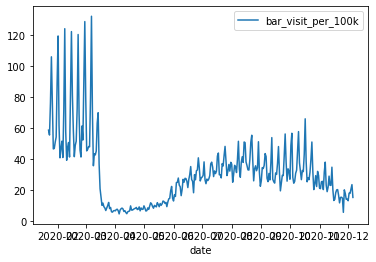

In [29]:
master_pd.plot.line(x='date', y='bar_visit_per_100k')

<AxesSubplot:xlabel='date'>

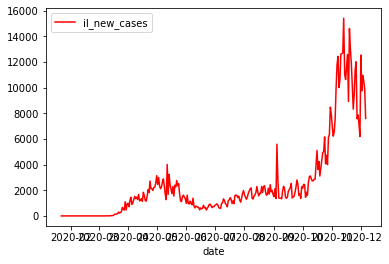

In [30]:
master_pd.plot.line(x='date', y='il_new_cases', color='r')

<AxesSubplot:xlabel='date'>

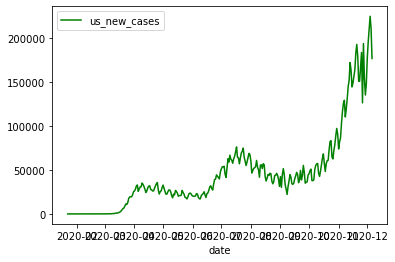

In [31]:
master_pd.plot.line(x='date', y='us_new_cases', color='g')

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
def line_plot(dta, ax, ay, title, ylb):
    plt.figure(figsize=(10, 6))
    plt.ticklabel_format(useOffset=False, style='plain')
    sns.set_theme(style='whitegrid')
    sns.lineplot(x=ax, y=ay, data=dta).set_title(title)
    plt.ylabel(ylb)
    
    return plt

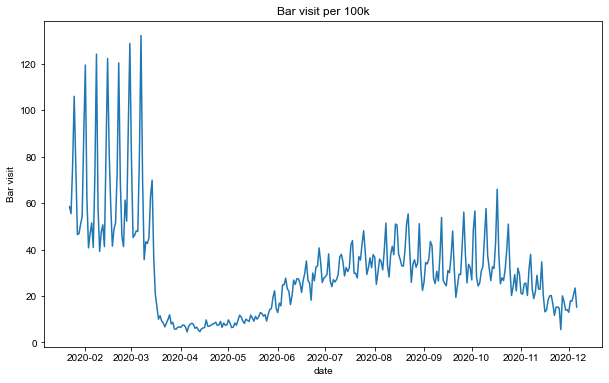

In [34]:
bv_plot = line_plot(master_pd, 'date', 'bar_visit_per_100k', 'Bar visit per 100k', 'Bar visit')
bv_plot.show()

In [46]:
master_pd_ma = master_pd.copy()
master_pd_ma = master_pd_ma.drop(['us_new_cases', 'il_new_cases', 'bar_visit_per_100k'], axis=1)
master_pd_ma['us_MA7'] = master_pd['us_new_cases'].rolling(window=7).mean()
master_pd_ma['il_MA7'] = master_pd['il_new_cases'].rolling(window=7).mean()
master_pd_ma['bar_MA7'] = master_pd['bar_visit_per_100k'].rolling(window=7).mean()

In [47]:
master_pd_ma

,date,us_MA7,il_MA7,bar_MA7
0,2020-01-22,NaN,NaN,NaN
1,2020-01-23,NaN,NaN,NaN
2,2020-01-24,NaN,NaN,NaN
3,2020-01-25,NaN,NaN,NaN
4,2020-01-26,NaN,NaN,NaN
...,...,...,...,...
315,2020-12-02,161422.857143,9019.428571,14.603516
316,2020-12-03,173404.142857,8867.571429,16.352440
317,2020-12-04,177847.857143,9289.285714,16.439886
318,2020-12-05,185926.571429,9577.000000,17.248763


In [48]:
master_pd_ma = master_pd_ma.dropna()
master_pd_ma

,date,us_MA7,il_MA7,bar_MA7
6,2020-01-28,0.000000,0.000000,66.387577
7,2020-01-29,0.000000,0.000000,65.283356
8,2020-01-30,0.000000,0.000000,65.104293
9,2020-01-31,0.000000,0.000000,67.029219
10,2020-02-01,0.000000,0.000000,68.954146
...,...,...,...,...
315,2020-12-02,161422.857143,9019.428571,14.603516
316,2020-12-03,173404.142857,8867.571429,16.352440
317,2020-12-04,177847.857143,9289.285714,16.439886
318,2020-12-05,185926.571429,9577.000000,17.248763


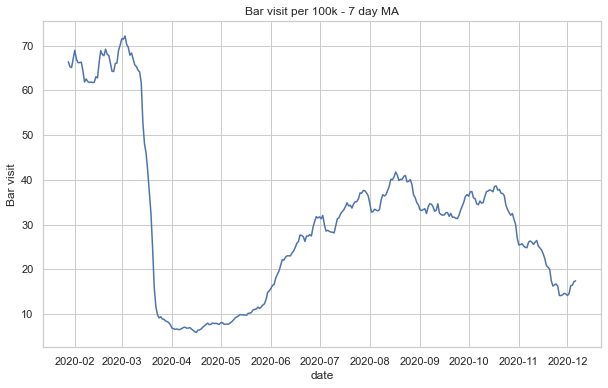

In [49]:
bv_ma_plot = line_plot(master_pd_ma, 'date', 'bar_MA7', 'Bar visit per 100k - 7 day MA', 'Bar visit')
bv_ma_plot.show()

In [50]:
def max_min_normalization(dta):
    max_val = dta.max()
    min_val = dta.min()
    
    nml = (dta-min_val) / (max_val-min_val)
    
    return nml

In [54]:
master_pd_ma['bar_MA7_nml'] = max_min_normalization(master_pd_ma['bar_MA7'])
master_pd_ma['us_MA7_nml'] = max_min_normalization(master_pd_ma['us_MA7'])
master_pd_ma['il_MA7_nml'] = max_min_normalization(master_pd_ma['il_MA7'])
master_pd_ma

<ipython-input-54-7467bf27e656>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_pd_ma['bar_MA7_nml'] = max_min_normalization(master_pd_ma['bar_MA7'])
<ipython-input-54-7467bf27e656>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_pd_ma['us_MA7_nml'] = max_min_normalization(master_pd_ma['us_MA7'])
<ipython-input-54-7467bf27e656>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

,date,us_MA7,il_MA7,bar_MA7,bar_MA7_nml,us_MA7_nml,il_MA7_nml
6,2020-01-28,0.000000,0.000000,66.387577,0.912879,0.000000,0.000000
7,2020-01-29,0.000000,0.000000,65.283356,0.896220,0.000000,0.000000
8,2020-01-30,0.000000,0.000000,65.104293,0.893519,0.000000,0.000000
9,2020-01-31,0.000000,0.000000,67.029219,0.922559,0.000000,0.000000
10,2020-02-01,0.000000,0.000000,68.954146,0.951600,0.000000,0.000000
...,...,...,...,...,...,...,...
315,2020-12-02,161422.857143,9019.428571,14.603516,0.131642,0.841361,0.728313
316,2020-12-03,173404.142857,8867.571429,16.352440,0.158027,0.903809,0.716051
317,2020-12-04,177847.857143,9289.285714,16.439886,0.159346,0.926970,0.750104
318,2020-12-05,185926.571429,9577.000000,17.248763,0.171549,0.969078,0.773337


In [45]:
master_pd_ma['date'] = pd.to_datetime(master_pd_ma['date'], format='%Y-%m-%d')
master_pd_ma

<ipython-input-45-b3b1766c82c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  master_pd_ma['date'] = pd.to_datetime(master_pd_ma['date'], format='%Y-%m-%d')


,date,us_MA7,il_MA7,bar_MA7,bar_MA7_nml,us_MA7_nml,il_MA7_nml
6,2020-01-28,0.000000,0.000000,66.387577,0.912879,0.000000,0.000000
7,2020-01-29,0.000000,0.000000,65.283356,0.896220,0.000000,0.000000
8,2020-01-30,0.000000,0.000000,65.104293,0.893519,0.000000,0.000000
9,2020-01-31,0.000000,0.000000,67.029219,0.922559,0.000000,0.000000
10,2020-02-01,0.000000,0.000000,68.954146,0.951600,0.000000,0.000000
...,...,...,...,...,...,...,...
315,2020-12-02,161422.857143,9019.428571,14.603516,0.131642,0.841361,0.728313
316,2020-12-03,173404.142857,8867.571429,16.352440,0.158027,0.903809,0.716051
317,2020-12-04,177847.857143,9289.285714,16.439886,0.159346,0.926970,0.750104
318,2020-12-05,185926.571429,9577.000000,17.248763,0.171549,0.969078,0.773337


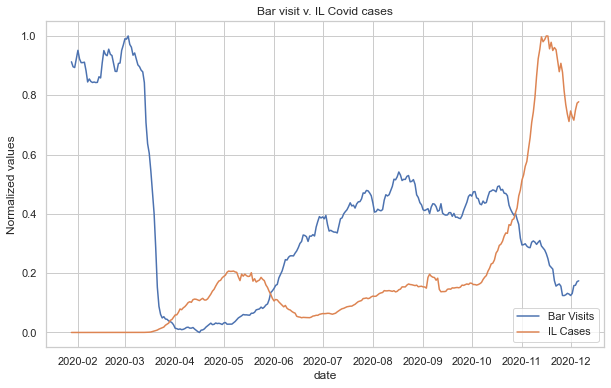

In [41]:
plt.figure(figsize=(10, 6))
plt.ticklabel_format(useOffset=False, style='plain')
sns.set_theme(style='whitegrid')
sns.lineplot(x='date', y='bar_MA7_nml', data=master_pd_ma, label='Bar Visits').set_title('Bar visit v. IL Covid cases')
sns.lineplot(x='date', y='il_MA7_nml', data=master_pd_ma, label='IL Cases')
plt.ylabel('Normalized values')
plt.show()

In [57]:
# Get Illinois case number from middle of June 2020 to October 2020.
after_midjune = master_pd_ma['date'] > pd.to_datetime('2020-06-15').date()
before_oct = master_pd_ma['date'] < pd.to_datetime('2020-10-01').date()
midjune_oct = after_midjune & before_oct
il_midjune_oct = master_pd_ma.loc[midjune_oct, ['date', 'il_MA7']]
il_midjune_oct

,date,il_MA7
146,2020-06-16,652.000000
147,2020-06-17,640.714286
148,2020-06-18,616.000000
149,2020-06-19,630.142857
150,2020-06-20,624.571429
...,...,...
248,2020-09-26,1965.857143
249,2020-09-27,1994.714286
250,2020-09-28,2027.857143
251,2020-09-29,2003.714286


In [58]:
after_may = master_pd_ma['date'] > pd.to_datetime('2020-05-01').date()
before_sept = master_pd_ma['date'] < pd.to_datetime('2020-09-01').date()
may_sept = after_may & before_sept
bar_may_sept = master_pd_ma.loc[may_sept, ['date', 'bar_MA7']]
bar_may_sept

,date,bar_MA7
101,2020-05-02,8.109202
102,2020-05-03,7.729549
103,2020-05-04,7.744471
104,2020-05-05,7.744471
105,2020-05-06,7.744471
...,...,...
218,2020-08-27,39.015393
219,2020-08-28,36.649566
220,2020-08-29,36.047732
221,2020-08-30,34.906325


In [59]:
il_midjune_oct['il_MA7_nml'] = max_min_normalization(il_midjune_oct['il_MA7'])
il_midjune_oct

,date,il_MA7,il_MA7_nml
146,2020-06-16,652.000000,0.019799
147,2020-06-17,640.714286,0.013592
148,2020-06-18,616.000000,0.000000
149,2020-06-19,630.142857,0.007778
150,2020-06-20,624.571429,0.004714
...,...,...,...
248,2020-09-26,1965.857143,0.742379
249,2020-09-27,1994.714286,0.758250
250,2020-09-28,2027.857143,0.776477
251,2020-09-29,2003.714286,0.763199


In [60]:
bar_may_sept['bar_MA7_nml'] = max_min_normalization(bar_may_sept['bar_MA7'])
bar_may_sept

,date,bar_MA7,bar_MA7_nml
101,2020-05-02,8.109202,0.011158
102,2020-05-03,7.729549,0.000000
103,2020-05-04,7.744471,0.000439
104,2020-05-05,7.744471,0.000439
105,2020-05-06,7.744471,0.000439
...,...,...,...
218,2020-08-27,39.015393,0.919490
219,2020-08-28,36.649566,0.849958
220,2020-08-29,36.047732,0.832270
221,2020-08-30,34.906325,0.798724


In [61]:
surge_2020 = pd.merge(il_midjune_oct, bar_may_sept, how='outer', left_on='date', right_on='date')
surge_2020

,date,il_MA7,il_MA7_nml,bar_MA7,bar_MA7_nml
0,2020-06-16,652.000000,0.019799,24.859902,0.503460
1,2020-06-17,640.714286,0.013592,25.785060,0.530651
2,2020-06-18,616.000000,0.000000,26.217796,0.543369
3,2020-06-19,630.142857,0.007778,27.665221,0.585909
4,2020-06-20,624.571429,0.004714,27.560768,0.582839
...,...,...,...,...,...
147,2020-06-11,NaN,NaN,23.009585,0.449080
148,2020-06-12,NaN,NaN,23.024507,0.449518
149,2020-06-13,NaN,NaN,22.994663,0.448641
150,2020-06-14,NaN,NaN,23.606461,0.466622


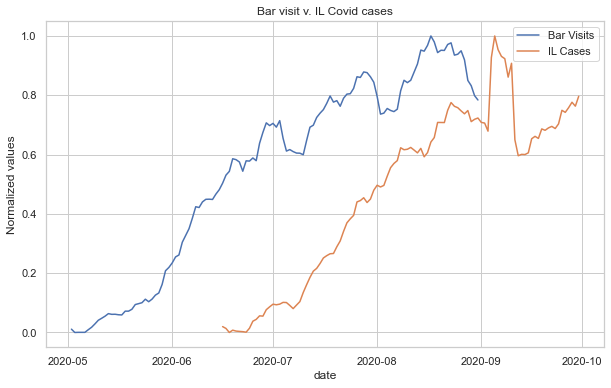

In [63]:
plt.figure(figsize=(10, 6))
plt.ticklabel_format(useOffset=False, style='plain')
sns.set_theme(style='whitegrid')
sns.lineplot(x='date', y='bar_MA7_nml', data=surge_2020, label='Bar Visits').set_title('Bar visit v. IL Covid cases')
sns.lineplot(x='date', y='il_MA7_nml', data=surge_2020, label='IL Cases')
plt.ylabel('Normalized values')
plt.show()